# Satellite Image to Map Image Translation using Pix2Pix GAN




## 1. Importing Libraries

In [1]:
import numpy as np
from numpy import asarray, load, vstack, zeros, ones
from numpy.random import randint
from os import listdir
from matplotlib import pyplot as plt
from keras.preprocessing.image import img_to_array, load_img
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate , Input
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.image import ssim
from numpy import savez_compressed
from sklearn.model_selection import train_test_split

In [2]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Loading and Visualizing the Dataset

Dataset Download Link - http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

In [3]:
# Function to load and preprocess images
def load_images(path, size=(256,512)):
    src_list, tar_list = list(), list()

    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):

        # load and resize the image
        pixels = load_img(path + filename, target_size=size)

        # convert to numpy array
        pixels = img_to_array(pixels)

        # split into satellite and map
        sat_img, map_img = pixels[:, :256], pixels[:, 256:]
        src_list.append(sat_img)
        tar_list.append(map_img)

    return [asarray(src_list), asarray(tar_list)]

# Dataset path
path = '/content/drive/MyDrive/maps/train/'
# path2 = '/content/drive/MyDrive/maps/val/'

# Load dataset
# [src_train, tar_train] = load_images(path)
# [src_val, tar_val] = load_images(path)

# # Combine the datasets
# src_images = asarray(list(src_train) + list(src_val))
# tar_images = asarray(list(tar_train) + list(tar_val))

# Split into train and test sets (80% train, 20% test)
# src_train, src_test, tar_train, tar_test = train_test_split(src_images, tar_images, test_size=0.2, random_state=42)

# Print shapes of the datasets
# print('Train dataset: ', src_train.shape, tar_train.shape)
# print('Test dataset: ', src_test.shape, tar_test.shape)

# New way
[src_images,tar_images] = load_images(path)
print('Dataset: ', src_images.shape, tar_images.shape)


Dataset:  (1096, 256, 256, 3) (1096, 256, 256, 3)


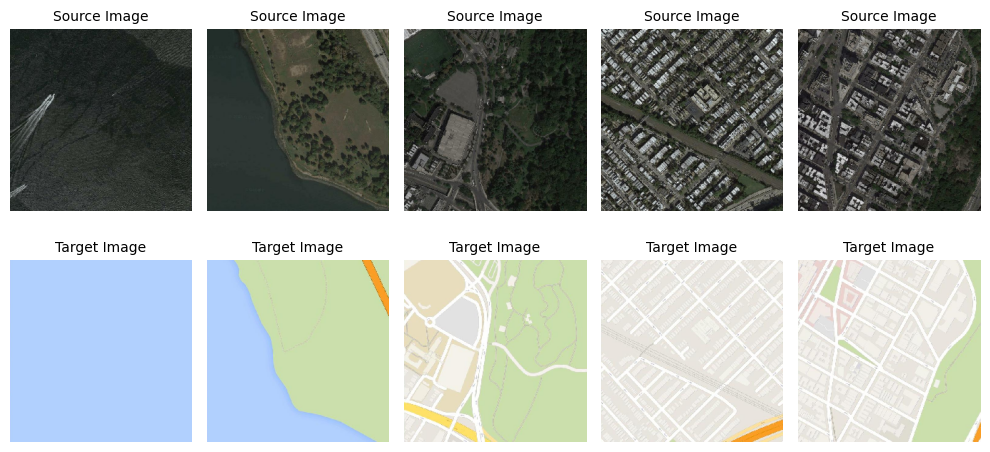

In [4]:
# Number of samples to visualize
n_samples = 5

plt.figure(figsize=(10, 5))

for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.title('Source Image', fontsize=10)  # Add a title to each source image
    plt.axis('off')
    plt.imshow(src_images[i].astype('uint8'))

for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.title('Target Image', fontsize=10)  # Add a title to each target image
    plt.axis('off')
    plt.imshow(tar_images[i].astype('uint8'))

plt.tight_layout()
plt.show()


## 3. Preprocessing the Dataset

In [5]:
# Converting the Scale of Images

def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]

	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# data_train = [src_train, tar_train]
# data_test = [src_test, tar_test]

# dataset_train = preprocess_data(data_train)
# dataset_test = preprocess_data(data_test)

dataset = [src_images, tar_images]
dataset = preprocess_data(dataset)

## 4. Defining the Pix2Pix GAN Model
Since pix2pix is a conditional GAN, it takes 2 inputs - image and corresponding label.

### Generator
Defining the Generator - in our case we will define a U-net

In [6]:
# define an encoder block to be used in generator
def define_encoder_block(layer_in, n_filters, batchnorm=True):

	  # weight initialization
	  init = RandomNormal(stddev=0.02)

	  # add downsampling layer
	  g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)

	  # conditionally add batch normalization
	  if batchnorm:
	  	g = BatchNormalization()(g, training=True)

	  # leaky relu activation
	  g = LeakyReLU(alpha=0.2)(g)

	  return g

# define a decoder block to be used in generator
def decoder_block(layer_in, skip_in, n_filters, dropout=True):

    # weight initialization
	  init = RandomNormal(stddev=0.02)

	  # add upsampling layer
	  g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)

	  # add batch normalization
	  g = BatchNormalization()(g, training=True)

	  # conditionally add dropout
	  if dropout:
	  	g = Dropout(0.5)(g, training=True)

	  # merge with skip connection
	  g = Concatenate()([g, skip_in])

	  # relu activation
	  g = Activation('relu')(g)
	  return g

In [7]:
# define the standalone generator model - U-net
def define_generator(image_shape=(256,256,3)):
	  # weight initialization
	  init = RandomNormal(stddev=0.02)

	  # image input
	  in_image = Input(shape=image_shape)

	  # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	  e1 = define_encoder_block(in_image, 64, batchnorm=False)
	  e2 = define_encoder_block(e1, 128)
	  e3 = define_encoder_block(e2, 256)
	  e4 = define_encoder_block(e3, 512)
	  e5 = define_encoder_block(e4, 512)
	  e6 = define_encoder_block(e5, 512)
	  e7 = define_encoder_block(e6, 512)
	  # bottleneck, no batch norm and relu

	  b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	  b = Activation('relu')(b)

	  # decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	  d1 = decoder_block(b, e7, 512)
	  d2 = decoder_block(d1, e6, 512)
	  d3 = decoder_block(d2, e5, 512)
	  d4 = decoder_block(d3, e4, 512, dropout=False)
	  d5 = decoder_block(d4, e3, 256, dropout=False)
	  d6 = decoder_block(d5, e2, 128, dropout=False)
	  d7 = decoder_block(d6, e1, 64, dropout=False)

	  # output
	  g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified
	  out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
	  # define model
	  model = Model(in_image, out_image)
	  return model

In [8]:
# gen_model = define_generator((256,256,3))
# plot_model(gen_model, to_file='gen_model.png', show_shapes=True)

### Discriminator
Given an input image, the Discriminator outputs the likelihood of the image being real.<br>
Binary classification - true or false (1 or 0). So using sigmoid activation.

In [9]:
# Structure - C64-C128-C256-C512. After the last layer, conv to 1-dimensional output, followed by a Sigmoid function.

# PatchGAN , which doesn't classify the entire image as real or fake but instead focuses on classifying patches of the image as real or fake.
def define_discriminator(image_shape):

	  # weight initialization
	  init = RandomNormal(stddev=0.02)

	  # source image input
	  in_src_image = Input(shape=image_shape)  #Image we want to convert to another image

	  # target image input
	  in_target_image = Input(shape=image_shape)  #Image we want to generate after training.

	  # concatenate images, channel-wise
	  merged = Concatenate()([in_src_image, in_target_image])

	  # C64: 4x4 kernel Stride 2x2
	  d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	  d = LeakyReLU(alpha=0.2)(d)

	  # C128: 4x4 kernel Stride 2x2
	  d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	  d = BatchNormalization()(d)
	  d = LeakyReLU(alpha=0.2)(d)

	  # C256: 4x4 kernel Stride 2x2
	  d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	  d = BatchNormalization()(d)
	  d = LeakyReLU(alpha=0.2)(d)

	  # C512: 4x4 kernel Stride 2x2
	  d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	  d = BatchNormalization()(d)
	  d = LeakyReLU(alpha=0.2)(d)
	  # second last output layer : 4x4 kernel but Stride 1x1
	  d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	  d = BatchNormalization()(d)
	  d = LeakyReLU(alpha=0.2)(d)

	  # patch output
	  d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	  patch_out = Activation('sigmoid')(d)
	  # define model
	  model = Model([in_src_image, in_target_image], patch_out)

	  # compile model
    # The model is trained with a batch size of one image, and Adam opts.
    # with a small learning rate and 0.5 beta.
    # The loss for the discriminator is weighted by 50% for each model update.

	  opt = Adam(learning_rate=0.0002, beta_1=0.5)
	  model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=0.5)

	  return model

In [10]:
# disc_model = define_discriminator((256,256,3))
# plot_model(disc_model, to_file='disc_model.png', show_shapes=True)

### GAN - Combined Generator and Descriminator

In [11]:
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False  # Discriminator layers set to untrainable in the combined GAN

    # define the source image
    in_src = Input(shape=image_shape)

    # supply the image as input to the generator
    gen_out = g_model(in_src)

    # supply the input image and generated image as inputs to the discriminator
    dis_out = d_model([in_src, gen_out])

    # src image as input, generated image and disc. output as outputs
    model = Model(in_src, [dis_out, gen_out])

    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)

    # Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    # Weighting BCE vs L1 (mae) as 1:100.
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])

    return model


In [12]:
# define input shape based on the loaded dataset
image_shape = src_images.shape[1:]

# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# plot_model(gan_model, to_file='gan_model.png', show_shapes=True)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


## 5. Function for Generating Real and Fake Samples for our GAN Model

In [13]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	  # unpack dataset
	  trainA, trainB = dataset

	  # choose random instances
	  ix = randint(0, trainA.shape[0], n_samples)

	  # retrieve selected images
	  X1, X2 = trainA[ix], trainB[ix]

	  # generate 'real' class labels (1)
	  y = ones((n_samples, patch_shape, patch_shape, 1))
	  return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):

	  # generate fake instance
	  X = g_model.predict(samples)

	  # create 'fake' class labels (0)
	  y = zeros((len(X), patch_shape, patch_shape, 1))
	  return X, y

## 6 Training and Evaluating our Pix2Pix GAN Model

In [14]:
# Generate samples and save as a plot and save the model
# GAN models do not converge, we just want to find a good balance between
# the generator and the discriminator. Therefore, it makes sense to periodically
# save the generator model and check how good the generated image looks.

import matplotlib.pyplot as plt

def summarize_performance(epoch, g_model, dataset, n_samples=5):
    # Select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)

    # Generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)

    # Scale all pixels from [-1, 1] to [0, 1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    # Plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.title('Source Image', fontsize=10)
        plt.axis('off')
        plt.imshow(X_realA[i])

    # Plot generated target images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.title('Generated Image', fontsize=10)
        plt.axis('off')
        plt.imshow(X_fakeB[i])

    # Plot real target images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.title('Real Target Image', fontsize=10)
        plt.axis('off')
        plt.imshow(X_realB[i])

    # Save plot to file
    filename1 = '/content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generated_images_epoch_%03d.png' % (epoch + 1)
    plt.savefig(filename1)
    plt.close()

    # Save the generator model
    filename2 = '/content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generator_model_epoch_%03d.h5' % (epoch + 1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

def calculate_batch_ssim(real_images, generated_images):

    # Ensure images are in the range [0, 1] using NumPy
    real_images = np.clip(real_images, 0.0, 1.0)
    generated_images = np.clip(generated_images, 0.0, 1.0)

    ssim_values = []

    # Loop over images in the batch
    for real, generated in zip(real_images, generated_images):
        # Calculate SSIM
        ssim_value = ssim(real, generated, max_val=1.0)
        ssim_values.append(K.eval(ssim_value))  # Convert from Tensor to numpy value

    # Average SSIM over the batch
    avg_ssim = np.mean(ssim_values)

    return avg_ssim


### Summarizing Model Performance with Plotting and Saving

### Training the Pix2Pix GAN Model

In [15]:
def train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1):
    # Determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]

    # Unpack dataset
    trainA, trainB = dataset

    # Calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)

    # Initialize the best SSIM (higher is better)
    best_ssim = -float('inf')

    # Loop over epochs
    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1}/{n_epochs}')
        batches_ssim = []

        for i in range(bat_per_epo):
            # Select a batch of real samples
            [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)

            # Generate a batch of fake samples
            X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

            # Update discriminator for real samples
            d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)

            # Update discriminator for generated samples
            d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

            # Update the generator
            g_loss, d_out, gen_out = gan_model.train_on_batch(X_realA, [y_real, X_realB])

            # Calculate SSIM for this batch
            batch_ssim = calculate_batch_ssim(X_realB, X_fakeB)

            # Print batch progress
            print(f'Batch {i+1}/{bat_per_epo}, d1[{d_loss1:.3f}] d2[{d_loss2:.3f}] g[{g_loss:.3f}] Batch SSIM[{batch_ssim:.4f}]')

        # Average SSIM over all batches in this epoch
        epoch_ssim = np.mean(batches_ssim)
        print(f'Epoch {epoch+1} Average SSIM: {epoch_ssim:.4f}')

        # Save the model if this is the best SSIM so far (higher is better)
        if epoch_ssim > best_ssim:
            best_ssim = epoch_ssim
            summarize_performance(epoch, g_model, dataset)

        print()

    print("Training complete.")

In [16]:
from datetime import datetime

start1 = datetime.now()

train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=10)
#Reports parameters for each batch (total 1096) for each epoch.
#For 10 epochs we should see
stop1 = datetime.now()

#Execution time of the model
execution_time = stop1-start1
print("Execution time is: ", execution_time)

Epoch 1/10
1/1 [==============================] - 1s 1s/step
Batch 1/109, d1[0.643] d2[0.764] g[74.597] Batch SSIM[0.0186]
1/1 [==============================] - 1s 582ms/step
Batch 2/109, d1[0.570] d2[0.454] g[79.830] Batch SSIM[0.0114]
1/1 [==============================] - 1s 563ms/step
Batch 3/109, d1[0.676] d2[0.473] g[73.950] Batch SSIM[0.0150]
1/1 [==============================] - 1s 617ms/step
Batch 4/109, d1[0.529] d2[0.597] g[69.539] Batch SSIM[0.0172]
1/1 [==============================] - 1s 577ms/step
Batch 5/109, d1[0.439] d2[0.478] g[62.166] Batch SSIM[0.0224]
1/1 [==============================] - 1s 599ms/step
Batch 6/109, d1[0.403] d2[0.438] g[67.365] Batch SSIM[0.0173]
1/1 [==============================] - 1s 538ms/step
Batch 7/109, d1[0.373] d2[0.389] g[65.883] Batch SSIM[0.0190]
1/1 [==============================] - 1s 615ms/step
Batch 8/109, d1[0.351] d2[0.383] g[59.380] Batch SSIM[0.0280]
1/1 [==============================] - 1s 558ms/step
Batch 9/109, d1[0.3

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved: /content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generated_images_epoch_001.png and /content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generator_model_epoch_001.h5

Epoch 2/10
1/1 [==============================] - 1s 562ms/step
Batch 1/109, d1[0.236] d2[0.207] g[11.019] Batch SSIM[0.3521]
1/1 [==============================] - 1s 504ms/step
Batch 2/109, d1[0.113] d2[0.104] g[12.802] Batch SSIM[0.3321]
1/1 [==============================] - 1s 539ms/step
Batch 3/109, d1[0.169] d2[0.048] g[13.376] Batch SSIM[0.2985]
1/1 [==============================] - 1s 508ms/step
Batch 4/109, d1[0.080] d2[0.109] g[12.131] Batch SSIM[0.3731]
1/1 [==============================] - 0s 480ms/step
Batch 5/109, d1[0.072] d2[0.044] g[12.734] Batch SSIM[0.3650]
1/1 [==============================] - 0s 454ms/step
Batch 6/109, d1[0.091] d2[0.040] g[12.212] Batch SSIM[0.4011]
1/1 [==============================] - 1s 578ms/step
Batch 7/109, d1[0.099] d2[0.046] g[12.538] Batch SSIM[0.3600]
1/1 [

>Saved: /content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generated_images_epoch_002.png and /content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generator_model_epoch_002.h5

Epoch 3/10
1/1 [==============================] - 0s 484ms/step
Batch 1/109, d1[0.414] d2[0.584] g[11.891] Batch SSIM[0.3754]
1/1 [==============================] - 0s 476ms/step
Batch 2/109, d1[0.164] d2[0.334] g[12.833] Batch SSIM[0.3658]
1/1 [==============================] - 1s 511ms/step
Batch 3/109, d1[0.918] d2[0.349] g[11.130] Batch SSIM[0.3362]
1/1 [==============================] - 1s 598ms/step
Batch 4/109, d1[0.108] d2[0.248] g[16.244] Batch SSIM[0.4247]
1/1 [==============================] - 0s 483ms/step
Batch 5/109, d1[0.344] d2[0.332] g[10.390] Batch SSIM[0.3759]
1/1 [==============================] - 1s 524ms/step
Batch 6/109, d1[0.405] d2[0.369] g[11.476] Batch SSIM[0.3817]
1/1 [==============================] - 0s 499ms/step
Batch 7/109, d1[0.365] d2[0.439] g[11.303] Batch SSIM[0.4348]
1/1 [

>Saved: /content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generated_images_epoch_003.png and /content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generator_model_epoch_003.h5

Epoch 4/10
1/1 [==============================] - 1s 517ms/step
Batch 1/109, d1[0.476] d2[0.289] g[11.379] Batch SSIM[0.5379]
1/1 [==============================] - 1s 508ms/step
Batch 2/109, d1[0.257] d2[0.324] g[10.809] Batch SSIM[0.4162]
1/1 [==============================] - 0s 468ms/step
Batch 3/109, d1[0.316] d2[0.294] g[10.674] Batch SSIM[0.4088]
1/1 [==============================] - 1s 506ms/step
Batch 4/109, d1[0.091] d2[0.240] g[13.383] Batch SSIM[0.3851]
1/1 [==============================] - 1s 553ms/step
Batch 5/109, d1[0.216] d2[0.193] g[13.911] Batch SSIM[0.4143]
1/1 [==============================] - 1s 510ms/step
Batch 6/109, d1[0.450] d2[0.243] g[10.161] Batch SSIM[0.3917]
1/1 [==============================] - 0s 476ms/step
Batch 7/109, d1[0.251] d2[0.432] g[10.735] Batch SSIM[0.3923]
1/1 [

>Saved: /content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generated_images_epoch_004.png and /content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generator_model_epoch_004.h5

Epoch 5/10
1/1 [==============================] - 0s 494ms/step
Batch 1/109, d1[0.068] d2[0.237] g[12.162] Batch SSIM[0.3908]
1/1 [==============================] - 1s 525ms/step
Batch 2/109, d1[0.054] d2[0.297] g[13.864] Batch SSIM[0.3674]
1/1 [==============================] - 1s 518ms/step
Batch 3/109, d1[0.365] d2[0.339] g[13.979] Batch SSIM[0.3879]
1/1 [==============================] - 0s 454ms/step
Batch 4/109, d1[0.615] d2[0.206] g[11.972] Batch SSIM[0.3978]
1/1 [==============================] - 0s 499ms/step
Batch 5/109, d1[0.111] d2[0.253] g[14.796] Batch SSIM[0.3080]
1/1 [==============================] - 0s 485ms/step
Batch 6/109, d1[0.234] d2[0.059] g[12.329] Batch SSIM[0.3178]
1/1 [==============================] - 1s 514ms/step
Batch 7/109, d1[0.084] d2[0.181] g[14.655] Batch SSIM[0.3391]
1/1 [

In [17]:
path2 = '/content/drive/MyDrive/maps/val/'

[src_images_val,tar_images_val] = load_images(path2)
dataset_val = [src_images_val, tar_images_val]
dataset_val = preprocess_data(dataset_val)

1/1 [==============================] - 0s 433ms/step


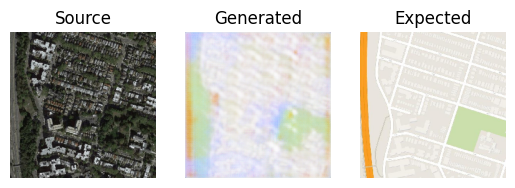

In [19]:
from keras.models import load_model
from numpy.random import randint
import matplotlib.pyplot as plt  # Add this import

# Load the pre-trained model
model = load_model('/content/drive/MyDrive/Pix2Pix_Generator_Saved_Model/generator_model_epoch_004.h5')

# Plot source, generated, and target images
def plot_images(src_img, gen_img, tar_img):
    images = vstack((src_img, gen_img, tar_img))
    # Scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    # Plot images row by row
    for i in range(len(images)):
        # Define subplot
        plt.subplot(1, 3, 1 + i)
        # Turn off axis
        plt.axis('off')
        # Plot raw pixel data
        plt.imshow(images[i])
        # Show title
        plt.title(titles[i])
    plt.show()

# Load validation dataset (assumed to be pre-loaded as dataset_val)
[X1, X2] = dataset_val
# Select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
# Generate image from source
gen_image = model.predict(src_image)
# Plot all three images
plot_images(src_image, gen_image, tar_image)
